# Fast Gradient Signed Method (FGSM) Adversarial Attack
In this notebook, we demonstrate the Fast Gradient Signed Method (FGSM) adversarial attack on a pre-trained CNN (ResNet18) using an image from ImageNet. We also discuss the effect of Gaussian noise compared to FGSM.

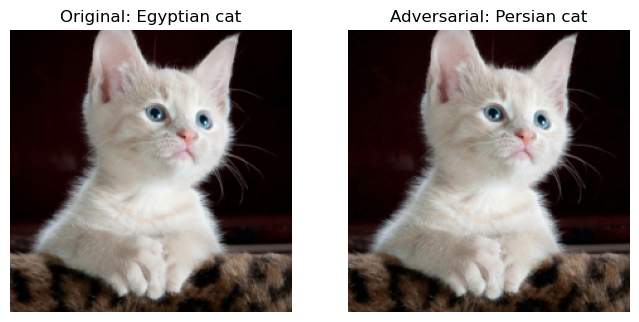

Original Prediction: Egyptian cat
Adversarial Prediction: Persian cat


In [8]:
# Import Required Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load Pre-trained ResNet18 Model
model = models.resnet18(pretrained=True).to(device)
model.eval()

# ImageNet class labels
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(LABELS_URL).text.splitlines()
# Download and Preprocess an ImageNet Image
# Example: "tabby cat" (class index 281)
img_url = "https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content)).convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_img = preprocess(img).unsqueeze(0).to(device)
# FGSM Attack Implementation
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Clamp to [0,1] after de-normalizing
    perturbed_image = torch.clamp(perturbed_image, -2.1179, 2.6400)  # min/max after normalization
    return perturbed_image

# Set requires_grad attribute of tensor
input_img.requires_grad = True
output = model(input_img)
init_pred = output.max(1, keepdim=True)[1]  # predicted class

# Calculate loss and gradients
criterion = nn.CrossEntropyLoss()
loss = criterion(output, init_pred.view(-1).long().to(output.device))
model.zero_grad()
loss.backward()
data_grad = input_img.grad.data

# FGSM attack
epsilon = 0.03
perturbed_data = fgsm_attack(input_img, epsilon, data_grad)
output_adv = model(perturbed_data)
final_pred = output_adv.max(1, keepdim=True)[1]
# Show Original and Adversarial Images with Predictions
def imshow(img_tensor, title=None):
    img = img_tensor.cpu().clone().squeeze(0)
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0, 1)
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
imshow(input_img, title=f"Original: {labels[init_pred.item()]}")
plt.subplot(1,2,2)
imshow(perturbed_data, title=f"Adversarial: {labels[final_pred.item()]}")
plt.show()

print(f"Original Prediction: {labels[init_pred.item()]}")
print(f"Adversarial Prediction: {labels[final_pred.item()]}")

## Discussion: FGSM vs. Gaussian Noise

FGSM is a targeted attack that uses the gradient of the loss with respect to the input image to create perturbations that specifically fool the model. In contrast, adding Gaussian noise is random and not optimized to mislead the model. While Gaussian noise can sometimes cause misclassification if the noise is strong enough, it is generally less effective than FGSM for generating adversarial examples. FGSM can fool the model with minimal, often imperceptible, changes, while Gaussian noise typically needs to be much stronger (and more visible) to have a similar effect.